In [9]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LinearSegmentedColormap
import sys

from scipy.interpolate import lagrange
from scipy.interpolate import interp1d
from scipy.interpolate import spline
from scipy.interpolate import BSpline
from scipy import special
argv = sys.argv
argc = len(argv)
IUNIT = 0 + 1j
Ev_const = 27.21138505

norb is 5
# number of orbital :  5
# im, m, iorb :  0 ,  -1 ,  2
# im, m, iorb :  0 ,  -1 ,  2
# im, m, iorb :  0 ,  -1 ,  2
# im, m, iorb :  0 ,  -1 ,  2
# im, m, iorb :  1 ,  0 ,  0
# im, m, iorb :  1 ,  0 ,  0
# im, m, iorb :  1 ,  0 ,  0
# im, m, iorb :  1 ,  0 ,  0
# im, m, iorb :  1 ,  0 ,  1
# im, m, iorb :  1 ,  0 ,  1
# im, m, iorb :  1 ,  0 ,  1
# im, m, iorb :  1 ,  0 ,  1
# im, m, iorb :  1 ,  0 ,  3
# im, m, iorb :  1 ,  0 ,  3
# im, m, iorb :  1 ,  0 ,  3
# im, m, iorb :  1 ,  0 ,  3
# im, m, iorb :  2 ,  1 ,  4
# im, m, iorb :  2 ,  1 ,  4
# im, m, iorb :  2 ,  1 ,  4
# im, m, iorb :  2 ,  1 ,  4
shape of phase: (3, 4, 400)
1 0
2 0
3 0
0 1
1 1
2 1
3 1
1 2
2 2
3 2
1 0
2 0
3

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:154: RuntimeWarning: invalid value encountered in true_divide


 0
0 1
1 1
2 1
3 1
1 2
2 2
3 2


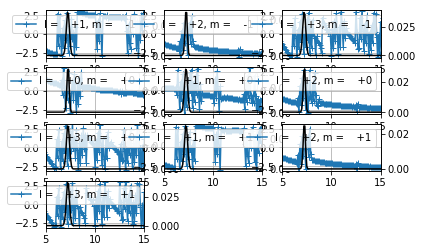

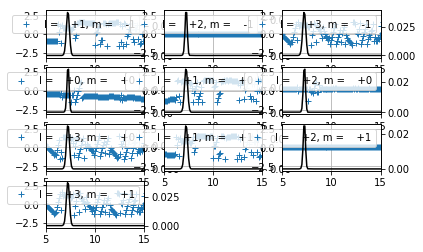

['l: 0, m: -1', 'l: 0, m: 0', 'l: 0, m: 1', 'l: 1, m: -1', 'l: 1, m: 0', 'l: 1, m: 1', 'l: 2, m: -1', 'l: 2, m: 0', 'l: 2, m: 1', 'l: 3, m: -1', 'l: 3, m: 0', 'l: 3, m: 1']
                    A             B
l: 0, m: -1  0.000000           NaN
l: 0, m: 0   0.018740 -5.909749e-01
l: 0, m: 1   0.000000           NaN
l: 1, m: -1  0.028734  8.213933e-01
l: 1, m: 0   0.034372  1.212440e+00
l: 1, m: 1   0.028734  8.213933e-01
l: 2, m: -1  0.024307  1.206230e-10
l: 2, m: 0   0.028436  2.385674e-01
l: 2, m: 1   0.024307 -0.000000e+00
l: 3, m: -1  0.037679  1.166744e+00
l: 3, m: 0   0.045767  1.406138e+00
l: 3, m: 1   0.037679  1.166744e+00


In [33]:
def main():

    w_fname = "wang.txt"

    fname = 'Ne.00.00.00.05.surff'


    with open(fname, "r") as fp:
        line = fp.readline()
        if len(list(line.strip()))  != 0:
            if list(line.strip())[0] == "#":
                #print(line)
                num_krad = int(fp.readline().strip("\n"))
                num_kang = int(fp.readline().strip("\n"))
                skipnum = 3
            else:
                skipnum = 2
                num_krad = int(line.strip("\n"))
                num_kang = int(fp.readline().strip("\n"))

    data = pd.read_csv(fname, comment="#", delim_whitespace=True, header=None, skiprows=skipnum)
    krad = data.iloc[:,0].values
    kang = data.iloc[:,1].values
    cval = data.iloc[:,2:].values
    #print(cval.shape)
    #print(len(data.iloc[0,:]) - 2)

    krad = krad.reshape(num_krad, num_kang)
    kang = kang.reshape(num_krad, num_kang)


    norb = int(len(cval[0,:]) / 2)
    print('norb is', norb)
    xang = np.cos(kang[0, :])

    lmax = 3
    mnum = 3
    mmax = 1
    val = np.zeros((norb, lmax+1, num_krad), dtype=np.complex)

    wdata = pd.read_csv(w_fname, comment="#", delim_whitespace=True, header=None, skiprows=0)
    wang = wdata.iloc[:, 2].values
    xang = wdata.iloc[:, 0].values

    print("# number of orbital : ", norb)
    m_list = [0, 0, -1, 0, 1]
    for iorb in range(norb):
        realp = cval[:,iorb*2].reshape(num_krad, num_kang)
        imagp = cval[:,iorb*2+1].reshape(num_krad, num_kang)

        for irad in range(num_krad):
                for l in range(lmax+1):
                    m = m_list[iorb]
                    if np.abs(m) > l:
                        continue
                    assoc_leg = special.lpmv(np.abs(m), l, xang)
                    """
                    #       ==============================
                    #       this part is missed in my code (td1c, surff_init)
                    """
                    fac = np.sqrt( (2.0*l+1.0) / 2.0 * np.math.factorial(l -  np.abs(m)) / np.math.factorial(l +  np.abs(m)))
                    sph_val = fac * assoc_leg
                    val[iorb, l, irad] = np.sum(wang * sph_val * (realp[irad,:] + IUNIT * imagp[irad,:]))
    m_list2 = [-1, 0, 1]
    val_msum = np.zeros((mnum, lmax+1, num_krad), dtype=np.complex)
    amp = np.zeros((mnum, lmax+1, num_krad))
    phase = np.zeros((mnum, lmax+1, num_krad))
    for im, m in enumerate(m_list2):
        for iorb in range(norb):
            for l in range(lmax+1):
                if m == m_list[iorb]:
                    print("# im, m, iorb : ",im,", ",  m, ", ", iorb)
                    val_msum[im, l, :] += val[iorb, l, :]

    amp = np.abs(val_msum)
    phase = np.arctan2(np.imag(val_msum), np.real(val_msum))
    print("shape of phase:", phase.shape)
    plt.figure()

    #ax1 = plt.subplot(211)
    #ax2 = plt.subplot(212)
    i = 0
    ax = []
    axt = []
    for im in range(mnum):
        for l in range(lmax+1):
            flag1 = (l == 0 and m_list2[im] ==  0)
            flag2 = (l == 1 and m_list2[im] == -1)
            flag3 = (l == 1 and m_list2[im] ==  0)
            flag4 = (l == 1 and m_list2[im] ==  1)
            flag5 = (l == 2 and m_list2[im] == -1)
            flag6 = (l == 2 and m_list2[im] ==  0)
            flag7 = (l == 2 and m_list2[im] ==  1)
            flag8 = (l == 3 and m_list2[im] ==  0)
            flag9 = (l == 3 and m_list2[im] == -1)
            flag10 = (l == 3 and m_list2[im] ==  1)
            #flag11 = (l == 2 and m_list2[im] ==  1)
            #flag12 = (l == 3 and m_list2[im] ==  0)
            #flag_tot = flag1 or
            flag_tot = flag1 or flag2  or flag3 or flag4 or flag5 or flag6 or flag7 or flag8 or flag9 or flag10

            if flag_tot:
                ax.append(plt.subplot(4,3,i+1))
                axt.append(ax[i].twinx())
                #print(i, len(ax))
                print(l, im)
                #v2 = val_msum / val_msum[2, 2, :]
                #ph = np.arctan(np.imag(v2) / np.real(v2))
                #ax[i].plot(0.5*krad[:, 0]**2 * 27.2, ph[im, l, :], "+", label = "l = {:+5d}, m = {:+5d}".format(l, m_list2[im]))
                ax[i].plot(0.5*krad[:, 0]**2 * Ev_const, phase[im, l, :], "+-", label = "l = {:+5d}, m = {:+5d}".format(l, m_list2[im]))
                axt[i].plot(0.5*krad[:, 0]**2 * Ev_const, amp[im, l, :], "k-", label = "l = {:+5d}, m = {:+5d}".format(l, m_list2[im]))
                #axt[i].set_yscale("log")
                #axt[i].set_ylim(10**-12, 0.035)

                ax[i].set_xlim(5, 15)
                #ax[i].set_xlim(10, 25)
                ax[i].set_ylim(-3.14, 3.14)

                ax[i].legend(loc='upper right')
                ax[i].grid()
                i = i + 1

    plt.figure()

    #ax1 = plt.subplot(211)
    #ax2 = plt.subplot(212)
    i = 0
    ax = []
    axt = []
    for im in range(mnum):
        for l in range(lmax+1):
            flag1 = (l == 0 and m_list2[im] ==  0)
            flag2 = (l == 1 and m_list2[im] == -1)
            flag3 = (l == 1 and m_list2[im] ==  0)
            flag4 = (l == 1 and m_list2[im] ==  1)
            flag5 = (l == 2 and m_list2[im] == -1)
            flag6 = (l == 2 and m_list2[im] ==  0)
            flag7 = (l == 2 and m_list2[im] ==  1)
            flag8 = (l == 3 and m_list2[im] ==  0)
            flag9 = (l == 3 and m_list2[im] == -1)
            flag10 = (l == 3 and m_list2[im] ==  1)
            #flag11 = (l == 2 and m_list2[im] ==  1)
            #flag12 = (l == 3 and m_list2[im] ==  0)
            #flag_tot = flag1 or
            flag_tot = flag1 or flag2  or flag3 or flag4 or flag5 or flag6 or flag7 or flag8 or flag9 or flag10


            if flag_tot:
                ax.append(plt.subplot(4,3,i+1))
                axt.append(ax[i].twinx())
                #print(i, len(ax))
                print(l, im)
                v2 = val_msum / val_msum[2, 2, :]
                ph = np.arctan(np.imag(v2) / np.real(v2))
                ax[i].plot(0.5*krad[:, 0]**2 * Ev_const, ph[im, l, :], "+", label = "l = {:+5d}, m = {:+5d}".format(l, m_list2[im]))


                #ax[i].plot(0.5*krad[:, 0]**2 * 27.2, phase[im, l, :], "+", label = "l = {:+5d}, m = {:+5d}".format(l, m_list2[im]))

                axt[i].plot(0.5*krad[:, 0]**2 * Ev_const, amp[im, l, :], "k-", label = "l = {:+5d}, m = {:+5d}".format(l, m_list2[im]))
                #axt[i].set_yscale("log")
                #axt[i].set_ylim(10**-12, 0.035)


                ax[i].set_xlim(5, 15)
                #ax[i].set_xlim(10, 25)
                ax[i].set_ylim(-3.14, 3.14)
                ax[i].legend(loc='upper right')
                ax[i].grid()
                i = i + 1

    max_amp = []    
    max_phase = []
    col = [] 
    df = pd.DataFrame(index = [], columns = [])
    for l in range(lmax+1):
        for im in range(mnum):
            col_name = "l: "+str(l) + ", " + "m: "+ str(m_list2[im])
            col_amp = "Amp" + col_name
            col_phase = "Ph_dif" + col_name
            df[col_amp]=amp[im, l, 65:83]
            df[col_phase]=ph[im, l, 65:83]
            max_amp.append(df[col_amp].max())   
            max_phase.append(df[col_phase][df[col_amp].idxmax()])
            col.append(col_name)
    plt.show()
    df.index = 0.5*krad[65:83, 0]**2 * Ev_const
    df.to_csv('amp.csv', mode='w')

    df1 = pd.DataFrame({'A': max_amp,'B': max_phase})
    df1.index = col


    print(df1)
#     df.to_csv('amp.csv', mode='w')


    return



if __name__ == "__main__":
    main()
